/home/nesma/anaconda3/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nesma/anaconda3/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, 1, 1, 10)          760       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 1, 1, 10)          0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 1, 10)             0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10)                840       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,611
Trainable params: 1,611
Non-trainable params: 0
_________________________________________________________________
Train on 34657 samples, validate on 8665 samples
Epoch 1/30
34657/34657 [==============================] - 5s 134us/step - loss: 0.0095 - va

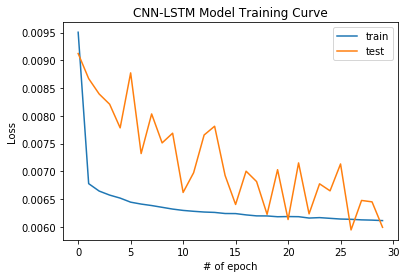

/home/nesma/anaconda3/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/home/nesma/anaconda3/envs/python/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


Test MSE: 4.367


In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense , LSTM, Flatten ,TimeDistributed
from keras.layers.convolutional import Conv1D , MaxPooling1D
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
import math


# #Importing team formation algorithm.
# from team_formation import *

def scale_data_toLSTM(X ,Y):
    # load dataset
    X =  pd.DataFrame(X)
    Y = pd.DataFrame(Y)
    values = X.values

    # integer encode direction
    # encoder = LabelEncoder() #Label encoding (one-hot) for player position at column no.= 9
    # values[:,position_col] = encoder.fit_transform(values[:,position_col])

    # ensure all data is float
    values = values.astype('float32')
    # normalize features
    scaler = MinMaxScaler(feature_range=(0, 1))
    X_scaled = scaler.fit_transform(values)
    Y_scaled = scaler.fit_transform(Y.values)
    
    # reshape input to be 4D [samples, subsequences, timesteps, features] and target data to be [samples,]
    X_scaled = X_scaled.reshape(X_scaled.shape[0],1,1,X_scaled.shape[1])
    Y_scaled = Y_scaled.reshape((Y_scaled.shape[0],))
    
    return (X_scaled , Y_scaled, scaler)



data = pd.read_csv('mergedDataset.csv')
data = data[['id', 'player_position', 'player_name', 'last10_ratio_cleanSheets_opp', 'last10_ratio_cleanSheets_own', 'last10_ratio_wins_opp', 'last10_ratio_wins_own', 'last3_assists', 'last3_goals', 'last3_ratio_points', 'last3_ycards', 'opp_team_rank', 'player_team_rank', 'player_value', 'ratio_assists', 'ratio_attempted_passes', 'ratio_big_chancesCreated', 'ratio_big_chancesMiss', 'ratio_creativity', 'ratio_dribbles', 'ratio_fouls', 'ratio_goals_conceded_opp_team', 'ratio_goals_conceded_player_team', 'ratio_goals_opp_team', 'ratio_goals_player_team', 'ratio_goals_scored', 'ratio_key_passes', 'ratio_leading_goal', 'ratio_minutes_played', 'ratio_offsides', 'ratio_open_playcross', 'ratio_own_goals', 'ratio_penalties_conceded', 'ratio_penalties_missed', 'ratio_penalties_saved', 'ratio_saves', 'ratio_selection', 'ratio_tackles', 'ratio_threat', 'week_no', 'season', 'week_points']]


#Split Training & Testing Set
data_refined = data.loc[:,[i for i in list(data.columns) if i not in ['id', 'player_name', 'player_team', 'season']]]
#one-hot encoding for player position
data_refined = pd.get_dummies(data_refined, columns = ['player_position', 'week_no'], drop_first=True)
X_train, X_test, Y_train, Y_test = train_test_split(data_refined.loc[:, data_refined.columns != 'week_points'], data_refined['week_points'], test_size=0.2, random_state=0)





test_X , test_y,scaler = scale_data_toLSTM(X_test, Y_test )
train_X , train_y,scaler = scale_data_toLSTM(X_train, Y_train)


# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=10, kernel_size=1, activation='relu'), input_shape=(1, 1, 75)))
model.add(TimeDistributed(MaxPooling1D(pool_size=1)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()


NO_BATCH_SIZE = 100 
NO_EPOCHS = 30

# fit model
history = model.fit(train_X, train_y, epochs=NO_EPOCHS, verbose=1, batch_size=NO_BATCH_SIZE,
                    validation_data=(test_X, test_y))

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.xlabel('# of epoch')
pyplot.ylabel('Loss')
pyplot.title("CNN-LSTM Model Training Curve")
pyplot.show()




test_X , test_y,scaler = scale_data_toLSTM(X_test, Y_test )
train_X , train_y,scaler = scale_data_toLSTM(X_train, Y_train)


yhat = model.predict(test_X)
test_X = test_X.reshape(((test_X.shape[0],test_X.shape[3])))


# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
mse = mean_squared_error(inv_y, inv_yhat)
print('Test MSE: %.3f' % mse)

      
                        



In [7]:


# test_X , test_y,scaler = scale_data_toLSTM(X_test, Y_test )
# train_X , train_y,scaler = scale_data_toLSTM(X_train, Y_train)


# yhatT = model.predict(train_X)
# # train_X = train_X.reshape(((train_X.shape[0],train_X.shape[2])))



# mse = mean_squared_error(train_y, yhatT)
# print('Test MSE: %.3f' % mse)

      
                        

